# Monte Carlo Simulation

## Preamble

### Imports

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
from scipy.stats import norm
import time
import requests
import json

### Helpers

In [3]:
def get_unix_time_minus_days(subtract_days):
    return int(time.time())-(86400*subtract_days)

def parse_unix_date(posix_time):
    return datetime.datetime.utcfromtimestamp(posix_time).strftime('%Y-%m-%dT%H:%M:%SZ')

def http_get(url):
    r = requests.get(url)
    data = json.loads(r.text)
    return data

## Ticker data

In [4]:
_5MIN = 300
_15MIN = 900
_30MIN = 1800
_2HR = 7200
_4HR = 14400
_DAY = 86400

In [5]:
def get_chart(pair, start, period):
    url = 'https://poloniex.com/public?command=returnChartData&currencyPair='+str(pair)+'&start='+str(start)+'&end=9999999999&period=' + str(period)
    return http_get(url)

In [6]:
raw = get_chart('USDT_BTC', get_unix_time_minus_days(365*3), _DAY)
raw[0:1]

[{'close': 244,
  'date': 1424304000,
  'high': 244,
  'low': 225,
  'open': 225,
  'quoteVolume': 0.19311748,
  'volume': 46.27631267,
  'weightedAverage': 239.62777823}]

In [7]:
len(raw)

1067

## Preprocessing

In [8]:
data = pd.DataFrame([[parse_unix_date(x['date']), float(x['close'])] for x in raw])[1]
data.tail()

1062    11102.697981
1063    11036.115325
1064    11010.000090
1065    11410.539249
1066    12847.319741
Name: 1, dtype: float64

In [9]:
log_returns = np.log(1 + data.pct_change())
log_returns.tail()

1062   -0.201410
1063   -0.006015
1064   -0.002369
1065    0.035733
1066    0.118598
Name: 1, dtype: float64

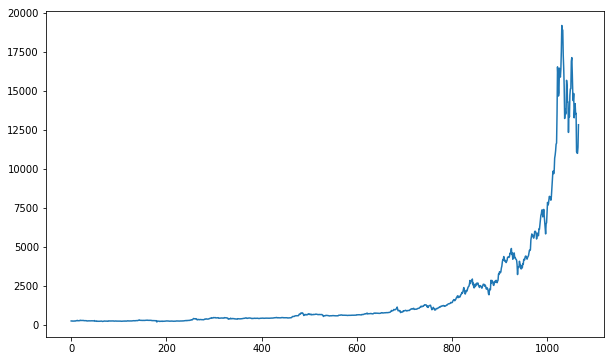

In [10]:
data.plot(figsize=(10,6));

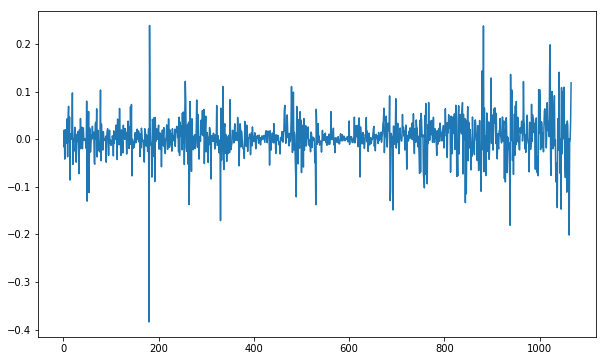

In [11]:
log_returns.plot(figsize=(10,6));

## Seed

In [12]:
u = np.array([log_returns.mean()])
u

array([ 0.00371831])

In [13]:
var = np.array([log_returns.var()])
var

array([ 0.00172476])

In [14]:
drift = np.array([u - (0.5 * var)])
drift

array([[ 0.00285593]])

In [15]:
stdev = np.array([log_returns.std()])
stdev

array([ 0.04153028])

## Monte Carlo simulation

In [16]:
t_intervals = 365
iterations = 100

In [17]:
daily_returns = np.exp(drift + stdev * norm.ppf(np.random.rand(t_intervals, iterations)))
daily_returns

array([[ 0.99952896,  0.99077745,  1.08259067, ...,  1.01721258,
         0.99617103,  0.97072421],
       [ 0.98623318,  1.0034722 ,  0.98784098, ...,  1.01655677,
         0.98704763,  0.99018147],
       [ 1.00432869,  0.97949261,  0.9441028 , ...,  1.01445087,
         0.96786195,  0.97666585],
       ..., 
       [ 0.98182072,  1.01684848,  0.96847892, ...,  1.05199822,
         1.01300938,  0.98447439],
       [ 1.0181299 ,  0.90195655,  0.959097  , ...,  0.95865019,
         0.96212192,  1.01243241],
       [ 1.01970454,  1.00140513,  1.02542298, ...,  0.99153047,
         0.98555767,  0.92272371]])

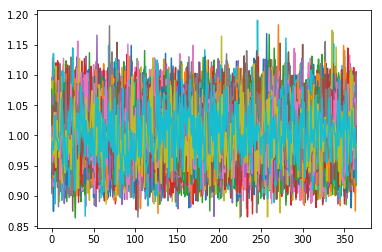

In [18]:
plot(daily_returns);

In [19]:
S0 = data.iloc[-1]
S0

12847.319741110001

In [20]:
price_list = np.zeros_like(daily_returns)
price_list

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [21]:
price_list[0] = S0
price_list

array([[ 12847.31974111,  12847.31974111,  12847.31974111, ...,
         12847.31974111,  12847.31974111,  12847.31974111],
       [     0.        ,      0.        ,      0.        , ...,
             0.        ,      0.        ,      0.        ],
       [     0.        ,      0.        ,      0.        , ...,
             0.        ,      0.        ,      0.        ],
       ..., 
       [     0.        ,      0.        ,      0.        , ...,
             0.        ,      0.        ,      0.        ],
       [     0.        ,      0.        ,      0.        , ...,
             0.        ,      0.        ,      0.        ],
       [     0.        ,      0.        ,      0.        , ...,
             0.        ,      0.        ,      0.        ]])

In [22]:
for t in range(1, t_intervals):
    price_list[t] = price_list[t - 1] * daily_returns[t]

In [23]:
price_list

array([[ 12847.31974111,  12847.31974111,  12847.31974111, ...,
         12847.31974111,  12847.31974111,  12847.31974111],
       [ 12670.45296759,  12891.92821562,  12691.10895623, ...,
         13060.02980765,  12680.9164556 ,  12721.17795832],
       [ 12725.29943847,  12627.54845989,  11981.71151674, ...,
         13248.75859837,  12273.37648151,  12424.34005859],
       ..., 
       [ 17131.44918804,  17155.29938963,  26424.38461981, ...,
         89955.88890818,   7536.02353807,  38913.86125097],
       [ 17442.04071283,  15473.33462161,  25343.54794556, ...,
         86236.22982051,   7250.57344522,  39397.65437018],
       [ 17785.72803305,  15495.07669932,  25987.85654109, ...,
         85505.84975699,   7145.85824997,  36353.14986587]])

## Plotting

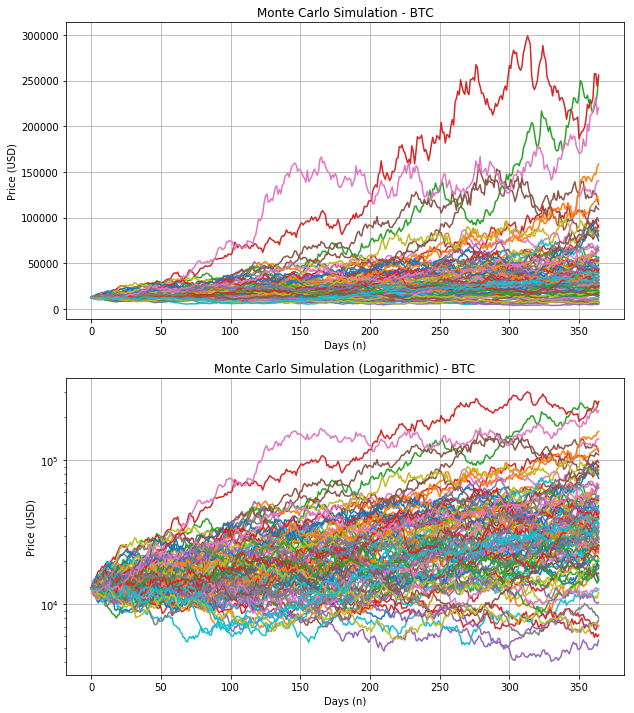

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,12))

plt.subplot(2,1,1)
plt.xlabel('Days (n)')
plt.ylabel('Price (USD)')
plt.title('Monte Carlo Simulation - BTC')
plt.grid()
plt.plot(price_list);

plt.subplot(2,1,2)
plt.xlabel('Days (n)')
plt.ylabel('Price (USD)')
plt.yscale('log')
plt.title('Monte Carlo Simulation (Logarithmic) - BTC')
plt.grid()
plt.plot(price_list);

plt.show()